In [78]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
def f(x):
    return 3*x**2 - 4*x + 5

In [80]:
f(3.0)

20.0

In [81]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

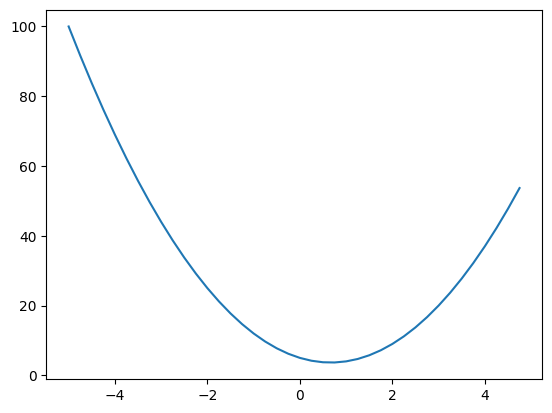

In [82]:
plt.plot(xs,ys)

In [83]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x)) / h

0.0

In [84]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c 
print(d)

4.0


In [85]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [86]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label;

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rmul__(self, other):
        return self * other

    def __neg__(self): # -self
        return self * -1

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
                
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad     
        
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')

e = a*b
d = e + c
e.label = 'e'
d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f
L.label = 'L'
L

Value(data=-8.0)

In [87]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [88]:
d._op

'+'

In [89]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

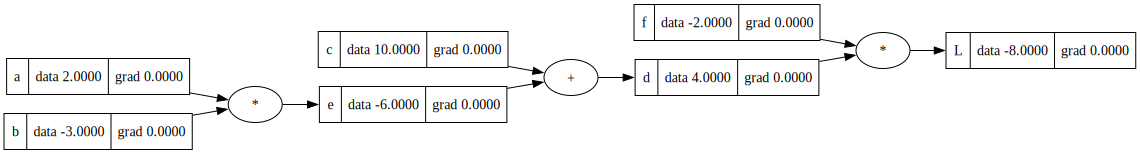

In [90]:
draw_dot(L)

In [91]:
L.grad = 1
d.grad = -2
f.grad = 4

# Local derivative of d with respect to e and c is 1
# We utilize the chain rule here

c.grad = -2
e.grad = -2

a.grad = (-2 * -3)
b.grad = (-2 * 2)

In [92]:
def lol():
    h = 0.001
       
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    
    e = a*b
    d = e + c
    e.label = 'e'
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    
    e = a*b
    d = e + c
    e.label = 'e'
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f
    L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

In [93]:
lol()

0.0


In [94]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = d * f

L.data

-7.286496

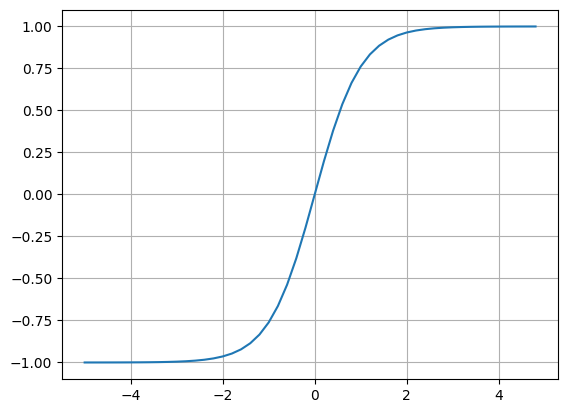

In [95]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [96]:
#inputs x1 x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

#weights w1 w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

#bias of the neuron
b = Value(6.8813735870195432, label = "b")

#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n"
o = n.tanh()
o.label = 'o'

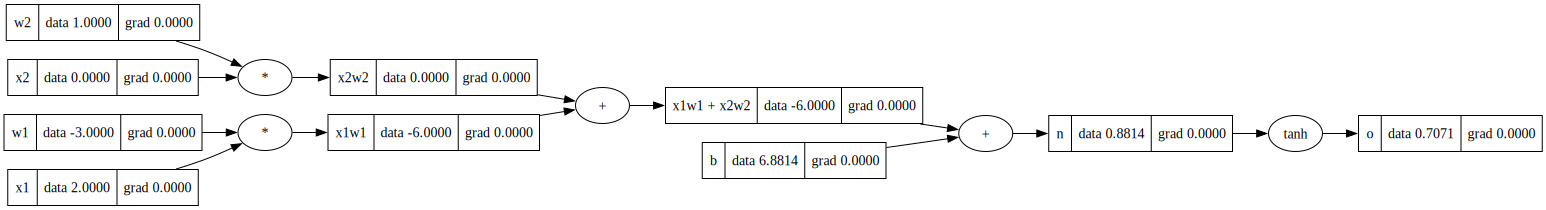

In [97]:
draw_dot(o)

In [98]:
o.grad = 1.0

In [99]:
# 1 - o**2
n.grad = 0.5

In [100]:
b.grad = 0.5
x1w1x2w2.grad = 0.5

In [101]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [102]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [103]:
o.grad = 1.0
o._backward()

In [104]:
n._backward()

In [105]:
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [106]:
# Topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [107]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

In [108]:
o.backward()

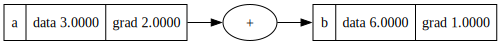

In [109]:
#Bug with using the same variable twice
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [110]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

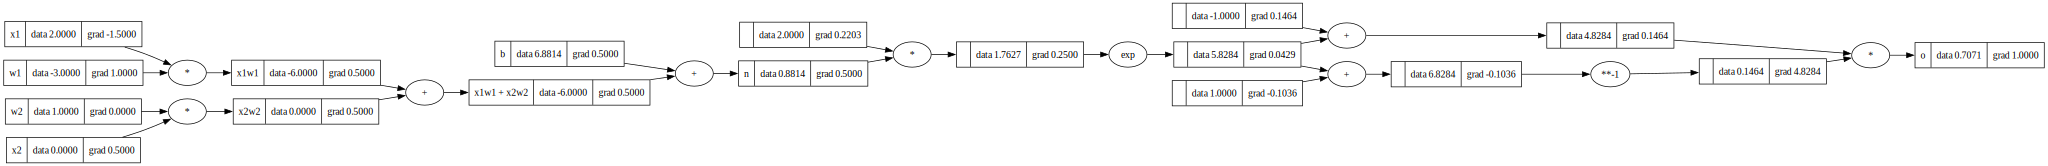

In [111]:
#inputs x1 x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

#weights w1 w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

#bias of the neuron
b = Value(6.8813735870195432, label = "b")

#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label = "n"

e = (2*n).exp()
o = (e - 1)/(e + 1)

o.label = 'o'
o.backward()
draw_dot(o)

In [112]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
w1 = torch.Tensor([0.0]).double(); w1.requires_grad = True
x2 = torch.Tensor([-3.0]).double(); x2.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

-0.9950547536867305
----
x2 0.009866037165440166
w2 -0.0295981114963205
x1 0.0
w1 0.019732074330880332


In [120]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin)for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [131]:
x = [2.0, 3.0, -1.0]
# n = Neuron(2)
n = MLP(3,[4,4,1])
n(x)

Value(data=0.24177518294054243)

In [122]:
len(n.parameters())

41

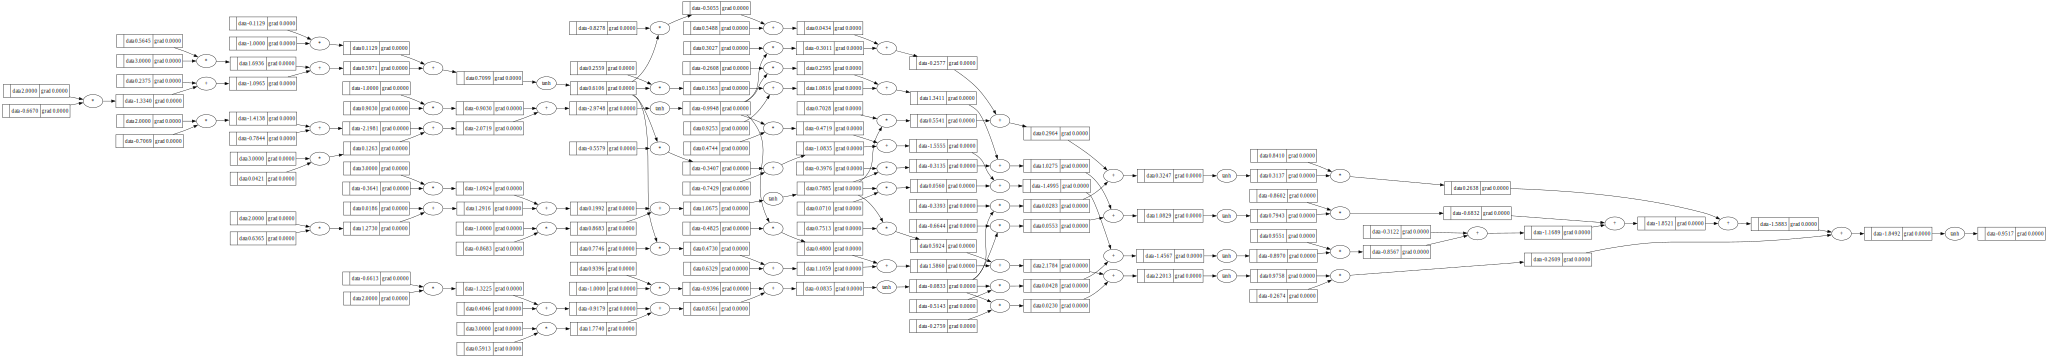

In [123]:
draw_dot(n(x))

In [148]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=0.24177518294054243),
 Value(data=0.5194568017054548),
 Value(data=0.7235676153376697),
 Value(data=0.34006902942352085)]

In [149]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=6.289848056020613)

In [150]:
loss.backward()

In [151]:
n.layers[0].neurons[0].w[0].grad

-6723.515623878782

In [152]:
n.layers[0].neurons[0].w[0].data

0.43663759917504796

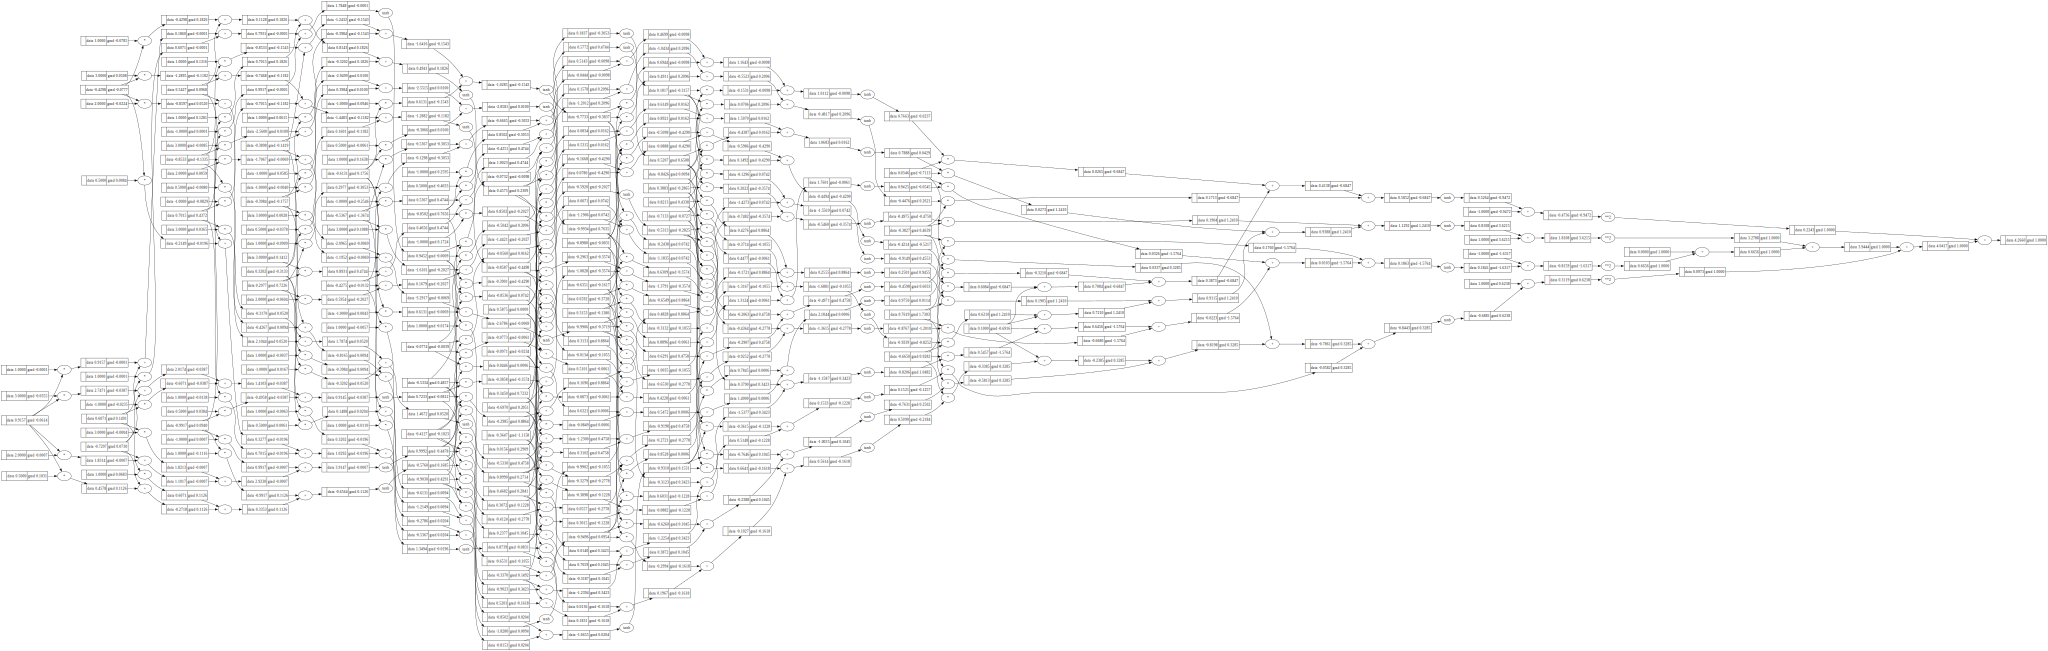

In [74]:
draw_dot(loss)